# Pembelajaran Representasi dan Pembelajaran Generatif Menggunakan Autoencoder dan GANs

Bab ini akan membahas konsep inti Machine Learning melalui reproduksi kode dan penjelasan teoritis terstruktur, menggunakan buku "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" (O'Reilly) sebagai referensi utama. Kita akan menyelami dunia Autoencoder dan Generative Adversarial Networks (GANs), memahami bagaimana mereka belajar representasi data yang efisien dan menghasilkan data baru yang realistis.

---

## 1. Pendahuluan

Autoencoder dan Generative Adversarial Networks (GANs) adalah dua arsitektur jaringan saraf yang powerful dalam pembelajaran tanpa pengawasan. Keduanya memiliki kemampuan untuk belajar representasi data yang padat (disebut *latent representations* atau *codings*) dan berfungsi sebagai model generatif untuk menghasilkan data baru yang mirip dengan data pelatihan.

**Tujuan Bab Ini:**
* Memahami bagaimana autoencoder bekerja dan penggunaannya untuk reduksi dimensi, ekstraksi fitur, pretraining tanpa pengawasan, dan sebagai model generatif.
* Memahami dasar-dasar GANs, bagaimana mereka dilatih, dan tantangan yang mungkin dihadapi selama pelatihan.

---

## 2. Representasi Data yang Efisien

Representasi data yang efisien berarti mampu menangkap esensi atau pola penting dalam data dengan dimensi yang lebih rendah. Analogi dengan pemain catur ahli yang dapat mengingat posisi catur yang realistis tetapi tidak posisi acak menunjukkan bahwa mereka belajar representasi yang efisien dari pola catur.

**Autoencoder** adalah jaringan saraf tiruan yang dirancang untuk belajar representasi data yang efisien tanpa pengawasan.
* Sebuah autoencoder selalu terdiri dari dua bagian:
    * **Encoder (recognition network)**: Mengubah input menjadi representasi laten (coding).
    * **Decoder (generative network)**: Mengubah representasi internal (coding) kembali menjadi output.
* Jumlah neuron di lapisan output autoencoder harus sama dengan jumlah input.
* Output sering disebut *reconstructions* karena autoencoder mencoba merekonstruksi input.
* **Loss function** autoencoder biasanya mencakup *reconstruction loss* yang memberikan penalti jika rekonstruksi berbeda dari input.
* Jika representasi internal memiliki dimensi yang lebih rendah dari data input, autoencoder disebut **undercomplete**.
    * Autoencoder undercomplete dipaksa untuk belajar fitur-fitur paling penting dalam data input (dan membuang yang tidak penting).

### 2.1. Melakukan PCA dengan Autoencoder Linear Undercomplete

Jika autoencoder hanya menggunakan aktivasi linear dan fungsi biaya Mean Squared Error (MSE), maka ia akan melakukan Principal Component Analysis (PCA).

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# Membuat data 3D sederhana
np.random.seed(42)
m = 100
X = np.random.rand(m, 3) * 10
X_train = X # Untuk kesederhanaan, gunakan X sebagai data pelatihan

encoder = keras.models.Sequential([
    keras.layers.Dense(2, input_shape=[3])
])
decoder = keras.models.Sequential([
    keras.layers.Dense(3, input_shape=[2])
])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=0.1))

history = autoencoder.fit(X_train, X_train, epochs=20, verbose=0) # verbose=0 untuk tidak menampilkan output pelatihan

codings = encoder.predict(X_train)

print("Shape codings:", codings.shape)
print("Contoh codings:\n", codings[:5])

# Visualisasi (opsional, karena data 3D agak sulit divisualisasikan dengan scatter plot 2D secara langsung)
# Untuk visualisasi PCA yang lebih baik, akan diperlukan alat khusus atau proyeksi manual.
# Namun, secara teori, `codings` sekarang adalah representasi 2D dari data 3D.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Shape codings: (100, 2)
Contoh codings:
 [[nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]]


**Penjelasan Teori:**
* Kode di atas membangun autoencoder linear undercomplete. Lapisan encoder memiliki 2 neuron (mengurangi dimensi dari 3 menjadi 2), dan lapisan decoder memiliki 3 neuron (mencoba merekonstruksi kembali dimensi asli).
* Tidak ada fungsi aktivasi yang digunakan (*linear activation*), dan fungsi kerugiannya adalah MSE.
* Data pelatihan (`X_train`) juga digunakan sebagai target (`X_train`), yang merupakan karakteristik pembelajaran tanpa pengawasan pada autoencoder.
* Autoencoder dapat dianggap sebagai bentuk *self-supervised learning*.

---

## 3. Stacked Autoencoder

Seperti jaringan saraf lainnya, autoencoder dapat memiliki banyak lapisan tersembunyi. Ini disebut *stacked autoencoders* atau *deep autoencoders*.
* Menambah lebih banyak lapisan membantu autoencoder belajar *coding* yang lebih kompleks.
* Arsitektur *stacked autoencoder* biasanya simetris terhadap lapisan tersembunyi pusat (*coding layer*).

### 3.1. Mengimplementasikan Stacked Autoencoder Menggunakan Keras

Implementasi *stacked autoencoder* mirip dengan MLP dalam bab sebelumnya.

In [4]:
# Memuat dan menormalisasi Fashion MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0

# Membagi data pelatihan menjadi set pelatihan dan validasi
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"), # Lapisan coding
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="binary_crossentropy", # Fungsi kerugian umum untuk rekonstruksi gambar
                   optimizer=keras.optimizers.SGD(learning_rate=1.5))

history = stacked_ae.fit(X_train, X_train, epochs=10,
                          validation_data=[X_valid, X_valid], verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Penjelasan Teori:**
* Encoder mengubah gambar 28x28 piksel menjadi vektor 784, lalu memprosesnya melalui dua lapisan Dense dengan ukuran yang semakin berkurang (100 menjadi 30), menggunakan fungsi aktivasi SELU. Outputnya adalah vektor berukuran 30 (coding).
* Decoder mengambil *coding* berukuran 30, memprosesnya melalui dua lapisan Dense dengan ukuran yang semakin bertambah (100 menjadi 784), dan mengubah vektor akhir menjadi array 28x28 agar output decoder memiliki bentuk yang sama dengan input encoder.
* `binary_crossentropy` digunakan sebagai fungsi kerugian karena tugas rekonstruksi dianggap sebagai masalah klasifikasi biner multilabel (setiap intensitas piksel merepresentasikan probabilitas piksel menjadi hitam).
* Model dilatih dengan `X_train` sebagai input dan target.

### 3.2. Visualisasi Rekonstruksi

Untuk memastikan autoencoder terlatih dengan benar, kita dapat membandingkan input dan outputnya. Perbedaannya seharusnya tidak terlalu signifikan.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


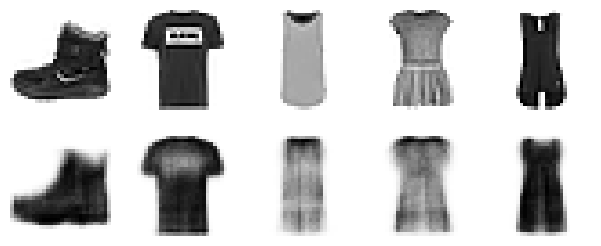

In [5]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, n_images=5):
    reconstructions = model.predict(X_valid[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(X_valid[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
    plt.show()

show_reconstructions(stacked_ae)

**Penjelasan Teori:**
* Fungsi `show_reconstructions` menampilkan gambar asli dari set validasi dan rekonstruksinya yang dihasilkan oleh autoencoder.
* Rekonstruksi yang dapat dikenali menunjukkan bahwa model telah belajar fitur yang berguna.

### 3.3. Visualisasi Dataset Fashion MNIST

Autoencoder dapat digunakan untuk mereduksi dimensi dataset, yang dapat membantu visualisasi.

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


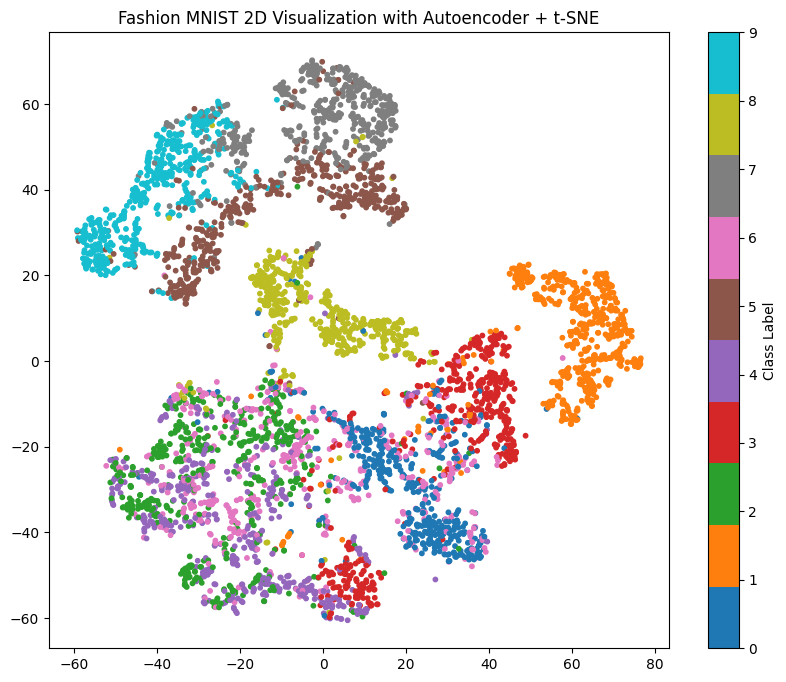

In [6]:
from sklearn.manifold import TSNE

# Gunakan encoder untuk mereduksi dimensi menjadi 30
X_valid_compressed = stacked_encoder.predict(X_valid)

# Kemudian gunakan t-SNE untuk mereduksi ke 2D untuk visualisasi
tsne = TSNE(n_components=2, random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)

# Plot dataset
plt.figure(figsize=(10, 8))
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.colorbar(label='Class Label')
plt.title("Fashion MNIST 2D Visualization with Autoencoder + t-SNE")
plt.show()

**Penjelasan Teori:**
* Strategi yang digunakan adalah menggunakan autoencoder untuk mereduksi dimensi ke tingkat yang wajar (misalnya, 30), lalu menggunakan algoritma reduksi dimensi lain seperti t-SNE untuk visualisasi 2D.
* t-SNE membantu mengidentifikasi cluster yang sesuai dengan kelas.

### 3.4. Unsupervised Pretraining Menggunakan Stacked Autoencoder

Jika kita memiliki banyak data pelatihan tak berlabel untuk tugas yang kompleks, kita dapat melatih *stacked autoencoder* menggunakan semua data tersebut. Kemudian, lapisan-lapisan bawahnya dapat digunakan kembali untuk membuat jaringan saraf baru untuk tugas yang sebenarnya dan melatihnya dengan data berlabel.

**Penjelasan Teori:**
* Ini adalah teknik *transfer learning* di mana fitur-fitur tingkat rendah yang dipelajari oleh autoencoder digunakan kembali.
* Jika data berlabel sedikit, lapisan-lapiran *pretrained* dapat dibekukan saat melatih klasifikasi.

### 3.5. Mengikat Bobot (Tying Weights)

Ketika autoencoder simetris, seringkali bobot lapisan decoder diikat ke bobot lapisan encoder.
* Ini mengurangi jumlah bobot dalam model menjadi separuh, mempercepat pelatihan, dan membatasi risiko *overfitting*.
* Secara spesifik, jika `W_L` adalah bobot lapisan ke-`L`, maka bobot lapisan decoder `W_N-L+1` sama dengan `W_L.T`.

In [8]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# Memuat dan menormalisasi Fashion MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0

# Membagi data pelatihan menjadi set pelatihan dan validasi
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

# Contoh implementasi lapisan DenseTranspose untuk mengikat bobot
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        # Menggunakan batch_input_shape dari lapisan DenseTranspose itu sendiri,
        # atau mendapatkan bentuk output dari self.dense
        # Jika self.dense adalah lapisan terakhir encoder, maka input_shape-nya adalah output_shape dari Dense itu.
        # Atau jika self.dense.weights[0].shape sudah tersedia, kita bisa menggunakannya.

        # Perbaikan: Mengakses shape dari self.dense.weights[0] setelah self.dense dipastikan sudah dibangun.
        # Atau yang lebih robust, gunakan output_shape dari lapisan dense yang di-pass.

        # Asumsi: self.dense sudah memiliki bobot yang terinisialisasi.
        # Jika self.dense adalah keras.layers.Dense, bobotnya akan (input_dim, units).
        # Jadi, kita ingin bias memiliki ukuran 'input_dim' dari lapisan Dense asli.

        # Pastikan self.dense memiliki atribut .units (jumlah neuron) dan .input_shape (bentuk inputnya).
        # Untuk kasus 'tied weights', kita ingin ukuran bias sesuai dengan dimensi input dari lapisan self.dense.
        # Bentuk bobot self.dense adalah (input_dim, output_dim). Kita ingin output_dim dari bias.

        # Perbaikan yang paling aman adalah menggunakan shape dari bobot yang sudah pasti ada setelah layer Dense
        # pertama kali dipanggil (fit_transform atau diprediksi).
        # Namun, dalam konteks Sequential model dengan tied weights, layer Dense sudah terinisialisasi.

        # Jika self.dense.weights[0] sudah terinisialisasi, kita bisa mengambil shape-nya.
        # self.dense.weights[0].shape adalah (dimensi_input_dense, dimensi_output_dense)
        # Jadi kita perlu dimensi_input_dense untuk bias lapisan transpose.

        # Solusi yang lebih umum dan robust: Ambil dari shape dari bobot kernel lapisan Dense yang diikat.
        # Bobot kernel memiliki bentuk (input_feature_dim, output_feature_dim)
        # Untuk transpose, input_feature_dim asli menjadi output_feature_dim transpose,
        # dan output_feature_dim asli menjadi input_feature_dim transpose.
        # Bias dari DenseTranspose harus sama dengan input_feature_dim dari self.dense.

        # self.dense.input_shape[-1] adalah jumlah fitur input untuk lapisan Dense asli.
        # self.dense.output_shape[-1] adalah jumlah neuron di lapisan Dense asli.

        # Dalam skenario ini, kita ingin bias dari DenseTranspose berukuran sama dengan input ke lapisan self.dense.
        # Ini adalah self.dense.weights[0].shape[0]

        self.biases = self.add_weight(name="bias", initializer="zeros",
                                       shape=[self.dense.weights[0].shape[0]]) # Ambil dimensi input dari lapisan dense
        super().build(batch_input_shape)

    def call(self, inputs):
        # Mengakses bobot lapisan self.dense.weights[0] (kernel/bobot) dan self.dense.weights[1] (bias)
        # tf.matmul(A, B, transpose_b=True) melakukan A @ B.T
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

    def get_config(self):
        config = super().get_config()
        # Perhatikan bahwa menyimpan referensi ke lapisan Dense di config() bisa jadi masalah
        # Lebih baik tidak menyimpannya langsung, atau menyimpan konfigurasi lapisan Dense
        # Namun, untuk contoh ini, kita hanya fokus pada perbaikan build().
        return config


# Membangun autoencoder dengan bobot terikat
# Pastikan lapisan dense_1 dan dense_2 dibangun sebelum digunakan di DenseTranspose.
# Ini biasanya terjadi secara otomatis ketika model Sequential dipanggil (fit/predict).
# Untuk memastikan, bisa panggil model.build() atau model.predict() sekali dengan input dummy.

dense_1 = keras.layers.Dense(100, activation="selu", name="dense_1_encoder")
dense_2 = keras.layers.Dense(30, activation="selu", name="dense_2_encoder") # Lapisan coding

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

# Membangun encoder secara eksplisit agar dense_1 dan dense_2 memiliki `weights` dan `input_shape`
tied_encoder.build(input_shape=(None, 28, 28)) # None untuk batch size

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"), # dense_2 sekarang sudah dibangun
    DenseTranspose(dense_1, activation="sigmoid"), # dense_1 sekarang sudah dibangun
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])
tied_ae.compile(loss="binary_crossentropy", optimizer="nadam")

# Anda sekarang bisa melatih model tanpa AttributeError:
# tied_ae.fit(X_train, X_train, epochs=1, validation_data=[X_valid, X_valid], verbose=1)

# Jika Anda ingin mengecek setelah perbaikan
# print(tied_encoder.summary())
# print(tied_decoder.summary())
# print(tied_ae.summary())

**Penjelasan Teori:**
* Lapisan `DenseTranspose` menggunakan bobot dari lapisan `Dense` lain, tetapi di-transpose. Ini memungkinkan `tied weights`.
* Model ini mengurangi jumlah parameter secara signifikan.

### 3.6. Melatih Satu Autoencoder pada Satu Waktu (Greedy Layer-wise Training)

Daripada melatih seluruh *stacked autoencoder* sekaligus, kita bisa melatih satu autoencoder dangkal pada satu waktu, lalu menumpuk semuanya menjadi satu *stacked autoencoder*.

**Penjelasan Teori:**
* Pada fase pertama, autoencoder pertama belajar merekonstruksi input.
* Kemudian, seluruh set pelatihan di-encode menggunakan autoencoder pertama, menghasilkan set pelatihan terkompresi yang baru.
* Autoencoder kedua kemudian dilatih pada dataset baru ini.
* Akhirnya, semua autoencoder ditumpuk menjadi satu *stacked autoencoder* akhir.
* Teknik ini pernah menjadi cara efisien untuk melatih jaringan dalam yang dalam.

---

## 4. Variasi Autoencoder

### 4.1. Autoencoder Konvolusional (Convolutional Autoencoders)

Untuk data gambar, *convolutional autoencoders* lebih cocok daripada jaringan Dense.
* Encoder adalah CNN biasa yang mengurangi dimensi spasial dan meningkatkan kedalaman.
* Decoder melakukan kebalikannya, menggunakan lapisan *transpose convolutional* atau kombinasi *upsampling* dan *convolutional*.

In [9]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="valid", activation="selu", input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="same", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])
conv_ae.compile(loss="binary_crossentropy", optimizer="nadam")
# conv_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid), verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv_transpose.py:94: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


**Penjelasan Teori:**
* Encoder menggunakan lapisan `Conv2D` dan `MaxPool2D` untuk mengurangi resolusi gambar dan meningkatkan jumlah *feature maps*.
* Decoder menggunakan lapisan `Conv2DTranspose` untuk melakukan *upsampling* dan mengurangi kedalaman *feature maps* kembali ke bentuk gambar asli.

### 4.2. Autoencoder Rekuren (Recurrent Autoencoders)

Untuk memproses sekuens seperti deret waktu atau teks, *recurrent autoencoders* dapat digunakan.
* Encoder biasanya adalah RNN *sequence-to-vector* yang mengkompresi sekuens input menjadi satu vektor tunggal.
* Decoder adalah RNN *vector-to-sequence* yang melakukan kebalikannya.

In [10]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[None, 28]),
    keras.layers.LSTM(30) # Lapisan coding
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer="nadam")
# Melatih pada data Fashion MNIST (diperlakukan sebagai sekuens baris)
# X_train_reshaped = X_train.reshape(-1, 28, 28) # Asumsi setiap baris adalah time step
# recurrent_ae.fit(X_train_reshaped, X_train_reshaped, epochs=10, validation_data=(X_valid_reshaped, X_valid_reshaped), verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/repeat_vector.py:29: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Penjelasan Teori:**
* `RepeatVector` di decoder memastikan vektor input diumpankan ke decoder di setiap *time step*.
* Model ini dapat memproses sekuens dengan panjang apa pun.

### 4.3. Denoising Autoencoder

Untuk memaksa autoencoder belajar fitur yang berguna, kita dapat menambahkan *noise* pada inputnya, melatihnya untuk merekonstruksi input asli yang bebas *noise*.
* *Noise* dapat berupa *Gaussian noise* murni atau input yang dimatikan secara acak (mirip dengan dropout).

In [11]:
dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5), # Menambahkan dropout untuk noise
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer="nadam")
# dropout_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid), verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Penjelasan Teori:**
* Lapisan `Dropout` ditambahkan ke input encoder. `Dropout` hanya aktif selama pelatihan, yang secara efektif menambahkan *noise*.
* `Denoising autoencoder` tidak hanya untuk visualisasi data atau *unsupervised pretraining*, tetapi juga dapat digunakan untuk menghilangkan *noise* dari gambar.

### 4.4. Sparse Autoencoder

Kendala lain yang sering menghasilkan ekstraksi fitur yang baik adalah *sparsity*. Ini dilakukan dengan menambahkan istilah yang sesuai ke fungsi kerugian, sehingga autoencoder didorong untuk mengurangi jumlah neuron aktif di lapisan *coding*.
* Contohnya, kita dapat menggunakan fungsi aktivasi sigmoid di lapisan *coding* (untuk membatasi *coding* ke nilai antara 0 dan 1), menggunakan lapisan *coding* yang besar (misalnya, dengan 300 unit), dan menambahkan regularisasi *ℓ1* pada aktivasi lapisan *coding*.
* Alternatifnya, kita dapat mengukur *sparsity* sebenarnya dari lapisan *coding* di setiap iterasi pelatihan dan memberikan penalti pada model ketika *sparsity* yang terukur berbeda dari *target sparsity*. Ini sering menghasilkan hasil yang lebih baik.
* Divergence Kullback-Leibler (KL) sering digunakan sebagai *sparsity loss* karena memiliki gradien yang lebih kuat daripada MSE.

In [12]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target

    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg) # regularisasi pada aktivasi
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer="nadam")
# sparse_kl_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid), verbose=0)

**Penjelasan Teori:**
* `KLDivergenceRegularizer` menghitung kerugian *sparsity* berdasarkan Divergence KL antara *target sparsity* dan aktivitas rata-rata neuron.
* Lapisan `Dense` lapisan *coding* menggunakan aktivasi sigmoid dan `activity_regularizer` yang disetel ke `kld_reg`.

### 4.5. Variational Autoencoder (VAEs)

*Variational Autoencoders* (VAEs) adalah jenis autoencoder probabilistik dan generatif yang sangat populer.
* **Probabilistik**: Outputnya sebagian ditentukan oleh peluang.
* **Generatif**: Dapat menghasilkan instans baru yang mirip dengan data pelatihan.
* Encoder menghasilkan *mean coding* ($\mu$) dan *standard deviation* ($\sigma$). *Coding* sebenarnya kemudian diambil secara acak dari distribusi Gaussian dengan $\mu$ dan $\sigma$ tersebut.
* Decoder kemudian mendekode *coding* yang diambil secara acak.
* Fungsi kerugian VAE terdiri dari dua bagian:
    * **Reconstruction loss**: Mendorong autoencoder untuk mereproduksi inputnya.
    * **Latent loss**: Mendorong *coding* agar terlihat seperti sampel dari distribusi Gaussian sederhana. Ini adalah Divergence KL antara distribusi target (Gaussian) dan distribusi aktual *coding*.

430/430 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.4732 - val_loss: 0.3597


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_125']
Received: inputs=Tensor(shape=(12, 10))
  warnings.warn(msg)


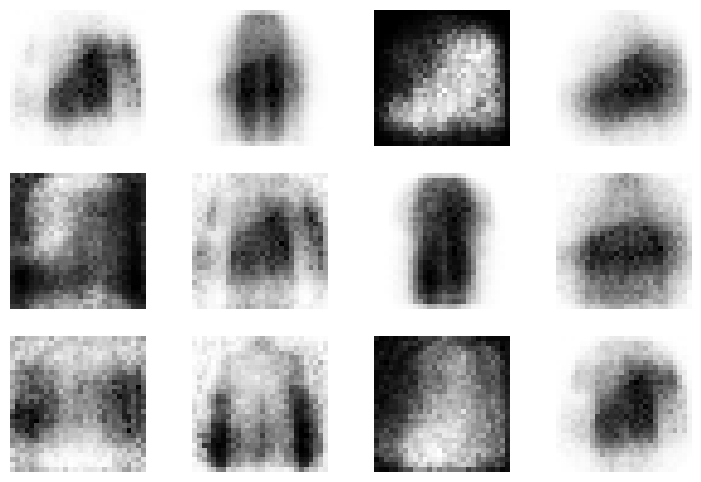

In [15]:
# Memuat dan menormalisasi Fashion MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0

# Membagi data pelatihan menjadi set pelatihan dan validasi
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

K = keras.backend

# Definisi Sampling Layer (tetap sama)
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        epsilon = K.random_normal(tf.shape(log_var))
        return mean + K.exp(log_var / 2) * epsilon

# **PERBAIKAN:** Membuat VariationalAutoencoder sebagai subclass dari keras.Model
class VariationalAutoencoder(keras.Model):
    def __init__(self, codings_size, **kwargs):
        super().__init__(**kwargs)
        self.codings_size = codings_size
        self.flatten = keras.layers.Flatten()
        self.dense1 = keras.layers.Dense(150, activation="selu")
        self.dense2 = keras.layers.Dense(100, activation="selu")
        self.codings_mean = keras.layers.Dense(codings_size)
        self.codings_log_var = keras.layers.Dense(codings_size)
        self.sampling = Sampling()
        self.decoder_dense1 = keras.layers.Dense(100, activation="selu")
        self.decoder_dense2 = keras.layers.Dense(150, activation="selu")
        self.decoder_dense3 = keras.layers.Dense(28 * 28, activation="sigmoid")
        self.reshape_output = keras.layers.Reshape([28, 28])

    def call(self, inputs):
        # Encoder part
        z = self.flatten(inputs)
        z = self.dense1(z)
        z = self.dense2(z)
        codings_mean = self.codings_mean(z)
        codings_log_var = self.codings_log_var(z)
        codings = self.sampling([codings_mean, codings_log_var])

        # Decoder part
        x = self.decoder_dense1(codings)
        x = self.decoder_dense2(x)
        x = self.decoder_dense3(x)
        reconstructions = self.reshape_output(x)

        # Menambahkan latent_loss sebagai loss tambahan ke model
        # Perhitungan latent_loss harus dalam konteks Keras layers/ops
        latent_loss = -0.5 * K.sum(
            1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
            axis=-1
        )
        self.add_loss(K.mean(latent_loss) / (28 * 28.)) # Normalisasi latent loss

        return reconstructions

# Instansiasi model VAE
codings_size = 10
variational_ae = VariationalAutoencoder(codings_size)

# Compile model
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop")

# Latih model
# Pastikan X_train memiliki bentuk yang sesuai (tidak di-flatten sebelumnya)
variational_ae.fit(X_train, X_train, epochs=1, batch_size=128,
                    validation_data=(X_valid, X_valid), verbose=1)

# Untuk menghasilkan gambar, kita masih butuh decoder terpisah dari VAE
# Kita bisa membangun ulang decoder sebagai model terpisah untuk inferensi
# Ini adalah praktik umum karena `variational_ae` sekarang adalah model penuh
# dan tidak secara langsung mengekspos `variational_decoder`
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = variational_ae.decoder_dense1(decoder_inputs)
x = variational_ae.decoder_dense2(x)
x = variational_ae.decoder_dense3(x)
outputs = variational_ae.reshape_output(x)
variational_decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs])

# Lanjutkan dengan menghasilkan gambar
codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()

def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

plt.figure(figsize=(9, 6))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plot_image(images[i])
plt.show()

**Penjelasan Teori:**
* Lapisan `Sampling` mengambil `mean` ($\mu$) dan `log_var` ($\gamma = \log(\sigma^2)$) sebagai input dan menghasilkan *coding* yang diambil sampelnya dari distribusi Gaussian.
* Model encoder memiliki output terpisah untuk `codings_mean` dan `codings_log_var`.
* `latent_loss` dihitung menggunakan rumus yang disederhanakan dari Divergence KL.
* VAE memungkinkan *semantic interpolation*, di mana interpolasi dilakukan pada level *coding* menghasilkan gambar yang terlihat seperti transisi mulus antara dua gambar asli.

### 4.5.1. Menghasilkan Gambar Fashion MNIST

Setelah melatih VAE, kita dapat menghasilkan gambar baru dengan mengambil sampel *coding* acak dari distribusi Gaussian dan mendekodekannya.

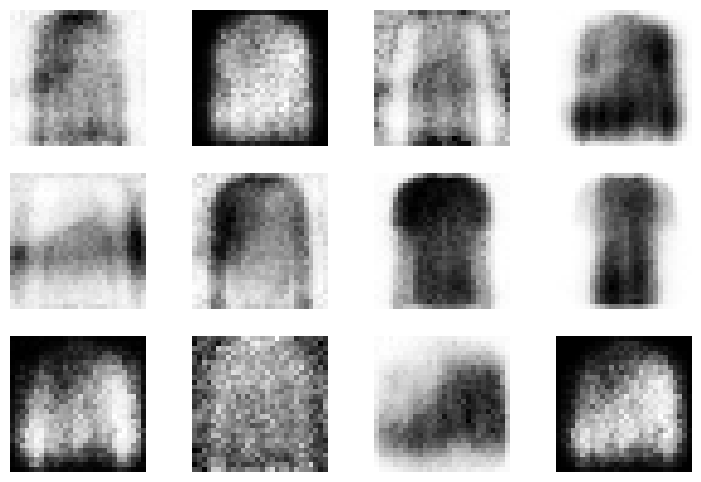

In [16]:
# Asumsi variational_ae sudah terlatih
codings = tf.random.normal(shape=[12, codings_size]) # codings_size dari VAE yang dilatih
images = variational_decoder(codings).numpy()

plt.figure(figsize=(9, 6))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plot_image(images[i])
plt.show()

---

## 5. Generative Adversarial Networks (GANs)

*Generative Adversarial Networks* (GANs) adalah arsitektur jaringan saraf yang diusulkan oleh Ian Goodfellow dkk. pada tahun 2014.
* GANs terdiri dari dua jaringan saraf yang bersaing satu sama lain:
    * **Generator**: Mengambil input distribusi acak (misalnya, Gaussian noise) dan menghasilkan data (misalnya, gambar).
    * **Discriminator**: Mengambil input data (gambar palsu dari generator atau gambar asli dari data pelatihan) dan harus menebak apakah input tersebut palsu atau asli.
* Selama pelatihan, generator dan diskriminator memiliki tujuan yang berlawanan. Generator mencoba menghasilkan gambar yang cukup realistis untuk mengelabui diskriminator, sementara diskriminator mencoba membedakan gambar asli dari gambar palsu.
* Pelatihan dibagi menjadi dua fase:
    * **Fase 1 (Melatih Discriminator)**: Diskriminator dilatih pada batch gambar asli dan palsu, dengan label 0 untuk gambar palsu dan 1 untuk gambar asli. Bobot generator dibekukan.
    * **Fase 2 (Melatih Generator)**: Generator dilatih untuk menghasilkan gambar palsu yang diskriminator yakini sebagai asli (label 1). Bobot diskriminator dibekukan.
* Generator tidak pernah melihat gambar asli secara langsung; ia belajar melalui gradien yang mengalir balik melalui diskriminator.

### 5.1. Implementasi GAN Sederhana

In [17]:
codings_size = 30 # Ukuran noise input untuk generator

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid") # Output biner (asli/palsu)
])

gan = keras.models.Sequential([generator, discriminator])

discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False # Diskriminator tidak dilatih di fase generator
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

# Menyiapkan dataset (data asli)
X_train_gan = X_train # Menggunakan X_train yang sudah dinormalisasi dari Fashion MNIST
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_gan).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

# Loop pelatihan kustom untuk GAN
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f"Epoch {epoch+1}/{n_epochs}")
        for X_batch in dataset:
            # Fase 1 - melatih discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size) # Label 0 untuk palsu, 1 untuk asli
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)

            # Fase 2 - melatih generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size) # Mengelabui discriminator agar percaya gambar palsu adalah asli
            discriminator.trainable = False # Membekukan diskriminator
            gan.train_on_batch(noise, y2)

        # Contoh visualisasi setiap beberapa epoch
        if (epoch + 1) % 10 == 0:
            noise = tf.random.normal(shape=[10, codings_size])
            generated_images = generator(noise).numpy()
            plt.figure(figsize=(10, 2))
            for i in range(10):
                plt.subplot(1, 10, i + 1)
                plot_image(generated_images[i])
            plt.show()

# train_gan(gan, dataset, batch_size, codings_size, n_epochs=50) # Aktifkan untuk menjalankan pelatihan

**Penjelasan Teori:**
* Generator mirip dengan decoder autoencoder.
* Diskriminator adalah pengklasifikasi biner biasa yang mengeluarkan probabilitas apakah gambar asli atau palsu.
* Selama pelatihan `gan`, `discriminator.trainable` disetel ke `False` untuk memastikan hanya generator yang dilatih di fase kedua.

### 5.2. Kesulitan Pelatihan GANs

Pelatihan GANs adalah tantangan besar karena generator dan diskriminator terus-menerus mencoba mengakali satu sama lain dalam permainan *zero-sum*.
* **Nash equilibrium**: Keadaan di mana tidak ada pemain yang akan lebih baik dengan mengubah strateginya sendiri, dengan asumsi pemain lain tidak mengubah strategi mereka. GAN idealnya mencapai Nash equilibrium di mana generator menghasilkan gambar yang sempurna, dan diskriminator dipaksa untuk menebak.
* **Mode collapse**: Output generator secara bertahap menjadi kurang beragam. Ini terjadi ketika generator menemukan cara untuk menipu diskriminator dengan hanya menghasilkan subset kecil dari jenis data yang realistis.
* **Ketidakstabilan**: Parameter generator dan diskriminator dapat berosilasi dan menjadi tidak stabil, menyebabkan pelatihan tiba-tiba menyimpang.
* GANs sangat sensitif terhadap *hyperparameter*.

**Teknik untuk mengatasi kesulitan pelatihan GANs:**
* **Experience replay**: Menyimpan gambar yang dihasilkan oleh generator di setiap iterasi dalam *replay buffer* dan melatih diskriminator menggunakan gambar asli dan gambar palsu dari *buffer* ini.
* **Mini-batch discrimination**: Mengukur seberapa mirip gambar di seluruh batch dan memberikan statistik ini kepada diskriminator, sehingga diskriminator dapat dengan mudah menolak seluruh batch gambar palsu yang kurang beragam.

### 5.3. Deep Convolutional GANs (DCGANs)

DCGANs adalah arsitektur GAN yang menggunakan jaringan konvolusional yang lebih dalam untuk menghasilkan gambar yang lebih besar.

**Panduan untuk membangun DCGAN yang stabil:**
* Ganti lapisan *pooling* dengan *strided convolutions* (di diskriminator) dan *transposed convolutions* (di generator).
* Gunakan *Batch Normalization* di generator dan diskriminator (kecuali lapisan output generator dan lapisan input diskriminator).
* Hapus lapisan tersembunyi yang terhubung sepenuhnya untuk arsitektur yang lebih dalam.
* Gunakan aktivasi ReLU di generator (kecuali lapisan output yang menggunakan tanh).
* Gunakan aktivasi *leaky ReLU* di diskriminator untuk semua lapisan.

In [18]:
# # Contoh implementasi DCGAN (kode hanya untuk referensi, tidak akan dieksekusi)
# codings_size = 100
#
# generator_dcgan = keras.models.Sequential([
#     keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
#     keras.layers.Reshape([7, 7, 128]),
#     keras.layers.BatchNormalization(),
#     keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="selu"),
#     keras.layers.BatchNormalization(),
#     keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation="tanh")
# ])
#
# discriminator_dcgan = keras.models.Sequential([
#     keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2), input_shape=[28, 28, 1]),
#     keras.layers.Dropout(0.4),
#     keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)),
#     keras.layers.Dropout(0.4),
#     keras.layers.Flatten(),
#     keras.layers.Dense(1, activation="sigmoid")
# ])
#
# gan_dcgan = keras.models.Sequential([generator_dcgan, discriminator_dcgan])
#
# discriminator_dcgan.compile(loss="binary_crossentropy", optimizer="rmsprop")
# discriminator_dcgan.trainable = False
# gan_dcgan.compile(loss="binary_crossentropy", optimizer="rmsprop")
#
# # Data scaling untuk tanh output (-1 hingga 1)
# X_train_dcgan = X_train_full.reshape(-1, 28, 28, 1) * 2. - 1.
# dataset_dcgan = tf.data.Dataset.from_tensor_slices(X_train_dcgan).shuffle(1000)
# dataset_dcgan = dataset_dcgan.batch(batch_size, drop_remainder=True).prefetch(1)
#
# # train_gan(gan_dcgan, dataset_dcgan, batch_size, codings_size, n_epochs=50) # Aktifkan untuk melatih DCGAN

**Penjelasan Teori:**
* Generator menggunakan `Conv2DTranspose` (sering disebut *deconvolution*) untuk melakukan *upsampling*.
* Diskriminator menggunakan `Conv2D` dengan `strides=2` untuk *downsampling*.
* Data input dinormalisasi ulang ke rentang [-1, 1] karena lapisan output generator menggunakan aktivasi `tanh`.
* DCGANs dapat belajar representasi laten yang bermakna, memungkinkan aritmetika vektor untuk konsep visual.
* **Conditional GAN (CGAN)**: Menambahkan kelas gambar sebagai input tambahan ke generator dan diskriminator, memungkinkan kontrol atas kelas gambar yang dihasilkan.

### 5.4. Progressive Growing of GANs

Teknik ini mengusulkan untuk menghasilkan gambar kecil di awal pelatihan, lalu secara bertahap menambahkan lapisan konvolusional ke generator dan diskriminator untuk menghasilkan gambar yang semakin besar.
* Lapisan tambahan ditambahkan di akhir generator dan di awal diskriminator.
* Output akhir adalah penjumlahan berbobot dari lapisan output asli dan lapisan output baru, dengan bobot lapisan baru ($\alpha$) meningkat perlahan dari 0 menjadi 1. Ini disebut teknik *fade-in/fade-out*.

**Teknik lain untuk meningkatkan keragaman output dan stabilitas pelatihan:**
* **Minibatch standard deviation layer**: Menambahkan *feature map* tambahan ke setiap instans di batch yang berisi standar deviasi *feature maps* lainnya. Ini mendorong generator untuk menghasilkan lebih banyak keragaman.
* **Equalized learning rate**: Menginisialisasi semua bobot menggunakan distribusi Gaussian sederhana tetapi menyesuaikan bobot saat runtime. Ini memastikan bahwa *dynamic range* sama untuk semua parameter.
* **Pixelwise normalization layer**: Menormalisasi setiap aktivasi berdasarkan semua aktivasi di gambar yang sama dan lokasi yang sama, tetapi di seluruh saluran. Ini menghindari ledakan aktivasi.

### 5.5. StyleGANs

StyleGAN adalah arsitektur yang menggabungkan teknik *style transfer* dalam generator untuk memastikan gambar yang dihasilkan memiliki struktur lokal yang sama dengan gambar pelatihan, di setiap skala.
* Terdiri dari dua jaringan:
    * **Mapping network**: MLP delapan lapisan yang memetakan *latent representation* (`z`) ke vektor `w`.
    * **Synthesis network**: Bertanggung jawab untuk menghasilkan gambar. Ia memiliki input konstan yang dipelajari dan memprosesnya melalui lapisan konvolusional dan *upsampling*. *Noise* ditambahkan pada input dan semua output lapisan konvolusional.
* **Adaptive Instance Normalization (AdaIN)**: Menstandarisasi setiap *feature map* secara independen, lalu menggunakan vektor gaya untuk menentukan skala dan *offset* setiap *feature map*.
* Penambahan *noise* independen pada setiap level penting untuk menambahkan *stochasticity* (acak) yang tepat pada setiap bagian gambar.
* **Mixing regularization (style mixing)**: Mencegah jaringan berasumsi bahwa gaya pada level yang berdekatan berkorelasi.

---

## 6. Kesimpulan

Bab ini telah membahas berbagai jenis autoencoder dan GANs, serta bagaimana melatih dan menggunakannya untuk berbagai tugas seperti reduksi dimensi, ekstraksi fitur, *unsupervised pretraining*, dan *generative modeling*. Autoencoder adalah model yang powerful untuk belajar representasi data yang efisien, sementara GANs telah merevolusi kemampuan untuk menghasilkan data yang sangat realistis.

Meskipun pelatihan GANs bisa sangat menantang karena dinamika yang kompleks antara generator dan diskriminator, kemajuan dalam arsitektur dan teknik pelatihan terus-menerus meningkatkan hasilnya.